In [ ]:
!pip install earthengine-api geemap --quiet

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt

In [ ]:
ee.Authenticate()
ee.Initialize(project = "usmannaziir-469710")

In [ ]:
REGION = ee.Geometry.Rectangle([
    74.1, 31.3,
    74.5, 31.7
])

YEARS = [2023, 2024, 2025]

VIZ_MIN = 1800
VIZ_MAX = 1950

In [ ]:
CH4_COLLECTION = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CH4')

In [ ]:
def january_image(year, region):

    start = ee.Date.fromYMD(year, 1, 1)
    end   = ee.Date.fromYMD(year, 1, 31)

    img = (
        CH4_COLLECTION
        .filterDate(start, end)
        .filterBounds(region)
        .map(lambda i: i.select(
            'CH4_column_volume_mixing_ratio_dry_air_bias_corrected'
        ).updateMask(
            i.select('CH4_column_volume_mixing_ratio_dry_air_uncertainty').lt(50)
            .And(i.select('solar_zenith_angle').lt(70))
        ))
        .mean()
        .clip(region)
    )

    return img


In [ ]:
Map = geemap.Map(center=[32.5, -102.5], zoom=6)

for year in YEARS:
    img = january_image(year, REGION)
    Map.addLayer(
        img,
        {
            'min': VIZ_MIN,
            'max': VIZ_MAX,
            'palette': [
                '0d0887','6a00a8','b12a90',
                'e16462','fca636','f0f921'
            ]
        },
        f'January {year} Mean CH₄'
    )

Map


Map(center=[32.5, -102.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
def january_mean_value(year, region):

    img = january_image(year, region)

    mean = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=7000,
        maxPixels=1e13
    )

    return mean.get(
        'CH4_column_volume_mixing_ratio_dry_air_bias_corrected'
    )


In [ ]:
# Export methane images for each year
import os
os.makedirs('data', exist_ok=True)

for year in YEARS:
    img = january_image(year, REGION)
    filename = f'data/methane_lahore_{year}.tif'
    print(f'Exporting {filename}...')
    geemap.download_ee_image(img, filename, scale=1000, region=REGION, crs='EPSG:4326')
    print(f'Exported {filename}')

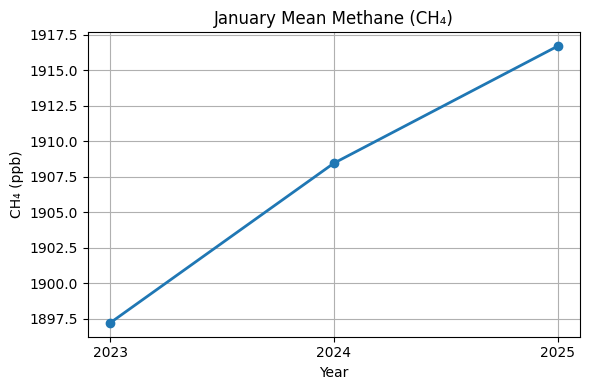

In [ ]:
years = []
values = []

for year in YEARS:
    val = january_mean_value(year, REGION).getInfo()
    years.append(year)
    values.append(val)

plt.figure(figsize=(6, 4))
plt.plot(years, values, marker='o', linewidth=2)

plt.xticks(years)

plt.xlabel('Year')
plt.ylabel('CH₄ (ppb)')
plt.title('January Mean Methane (CH₄)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd

# Save the data to CSV
df = pd.DataFrame({'year': years, 'methane_ppb': values})
df.to_csv('data/lahore_methane_years.csv', index=False)
print("Data saved to data/lahore_methane_years.csv")